One common strategy used to prevent overfitting is early stopping.

Let's see a model trained with and without early stopping below to see how it works

In [47]:
import torch
import torch.nn as nn

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [48]:
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Use Sigmoid for binary classification or softmax for multi-class
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [49]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

NUM_FEATURES = 20
X, y = make_classification(n_samples=10000, n_features=NUM_FEATURES, n_classes=2, n_informative=8, random_state=42)
# X, y = make_blobs(n_samples=1000, centers=2, n_features=NUM_FEATURES, random_state=42, cluster_std=8.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
train_data = torch.tensor(X_train, dtype=torch.float32).to(device)
train_labels = torch.tensor(y_train, dtype=torch.float32).to(device)
val_data = torch.tensor(X_val, dtype=torch.float32).to(device)
val_labels = torch.tensor(y_val, dtype=torch.float32).to(device)
test_data = torch.tensor(X_test, dtype=torch.float32).to(device)
test_labels = torch.tensor(y_test, dtype=torch.float32).to(device)

print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}"
      f"\nValidation data shape: {val_data.shape}, Validation labels shape: {val_labels.shape}"
      f"\nTest data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

Train data shape: torch.Size([7000, 20]), Train labels shape: torch.Size([7000])
Validation data shape: torch.Size([1500, 20]), Validation labels shape: torch.Size([1500])
Test data shape: torch.Size([1500, 20]), Test labels shape: torch.Size([1500])


7000 7000


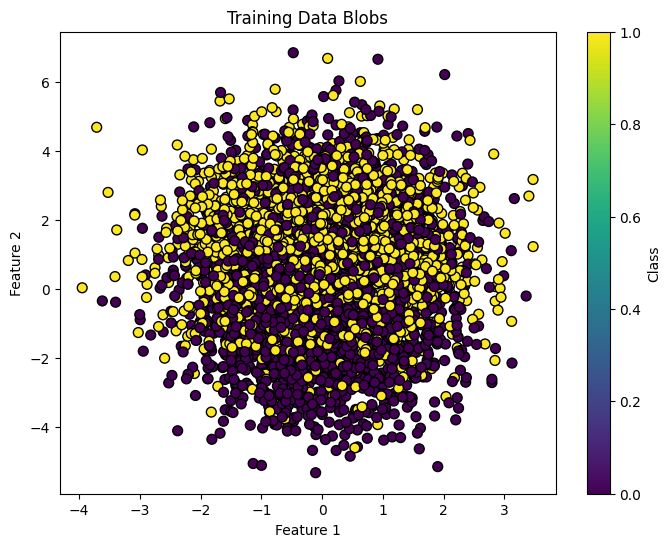

1500 1500


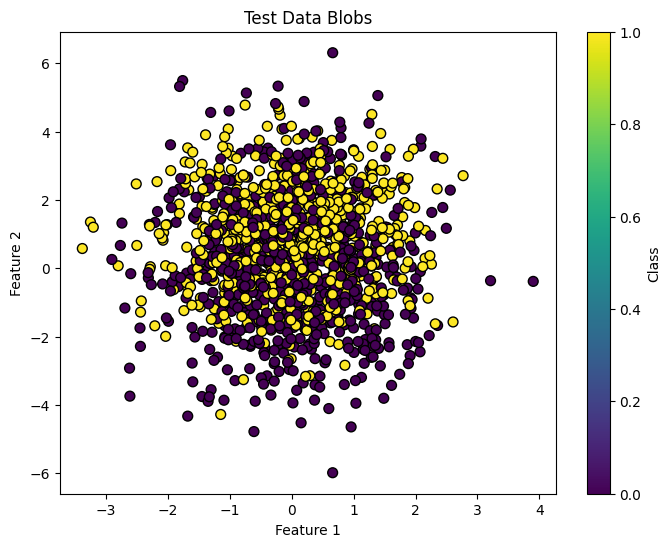

In [50]:
# plot blobs
import matplotlib.pyplot as plt

def plot_blobs(X, y, title="Blobs"):
    print(len(X), len(y))
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label="Class")
    plt.show()

plot_blobs(train_data.cpu(), train_labels.cpu(), title="Training Data Blobs")
plot_blobs(test_data.cpu(), test_labels.cpu(), title="Test Data Blobs")

In [51]:
import abc


class EarlyStoppingBase(abc.ABC):
    @abc.abstractmethod
    def __init__(self, patience: int = 5, min_delta: float = 0.0) -> None:
        raise NotImplementedError("This method should be overridden by subclasses")
        
    @abc.abstractmethod
    def __call__(self, loss: float) -> bool:
        raise NotImplementedError("This method should be overridden by subclasses")

In [52]:
class NoEarlyStopping(EarlyStoppingBase):
    def __init__(self, patience: int = 5, min_delta: float = 0.0) -> None:
        ...

    def __call__(self, loss: float) -> bool:
        return False

In [53]:
class EarlyStopping(EarlyStoppingBase):
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, loss: float) -> bool:
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [54]:
import typing


def train_loop(model: nn.Module, train_data: torch.Tensor, train_labels: torch.Tensor, 
               val_data: torch.Tensor, val_labels: torch.Tensor, early_stopping: EarlyStoppingBase, 
               loss_fn: nn.Module, optimizer: torch.optim.Optimizer) -> typing.Tuple[typing.List[float], typing.List[float]]:
    train_losses = []
    val_losses = []
    for epoch in range(1000):  # Assuming a maximum of 100 epochs
        model.train()
        optimizer.zero_grad()
        outputs = model(train_data).squeeze()
        loss = loss_fn(outputs, train_labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.inference_mode():
            val_outputs = model(val_data).squeeze()
            train_accuracy = (outputs.round() == train_labels).float().mean().item()
            accuracy = (val_outputs.round() == val_labels).float().mean().item()
            val_loss = loss_fn(val_outputs, val_labels)
            val_losses.append(val_loss.item())
            print(f"Epoch {epoch+1}, Train accuracy: {train_accuracy*100:.2f}%   Train Loss: {loss:.2f} | Val accuracy: {accuracy*100:.2f}%  Val Loss: {val_loss:.2f}")

        if early_stopping(val_loss.item()):
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses

In [55]:
import matplotlib.pyplot as plt

def plot_losses(train_losses: typing.List[float], val_losses: typing.List[float], test_loss: float) -> None:
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Val loss")
    print(test_loss)
    plt.axhline(y=test_loss, color='r', linestyle='--', label="Test loss")
    plt.title("Losses over time")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.ylim(0, 3)
    plt.legend()
    plt.show()

In [56]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(predictions: torch.Tensor, labels: torch.Tensor, n_bins: int = 10) -> None:
    prob_true, prob_pred = calibration_curve(labels.cpu(), predictions.cpu(), n_bins=n_bins)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--',
                color='gray', label='Perfectly calibrated')
    plt.title("Calibration Curve")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.grid()
    plt.show()

In [57]:
# train a model with no early stopping
model_0 = SimpleModel(input_size=NUM_FEATURES).to(device)
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
early_stopping = NoEarlyStopping(patience=5, min_delta=0.01)
train_losses, val_losses = train_loop(model_0, train_data, train_labels, val_data, val_labels, early_stopping, loss_fn, optimizer)

Epoch 1, Train accuracy: 50.20%   Train Loss: 0.69 | Val accuracy: 47.87%  Val Loss: 0.69
Epoch 2, Train accuracy: 50.20%   Train Loss: 0.69 | Val accuracy: 47.87%  Val Loss: 0.69
Epoch 3, Train accuracy: 50.20%   Train Loss: 0.69 | Val accuracy: 47.87%  Val Loss: 0.69
Epoch 4, Train accuracy: 50.20%   Train Loss: 0.68 | Val accuracy: 47.87%  Val Loss: 0.68
Epoch 5, Train accuracy: 50.20%   Train Loss: 0.68 | Val accuracy: 47.87%  Val Loss: 0.68
Epoch 6, Train accuracy: 50.21%   Train Loss: 0.67 | Val accuracy: 48.87%  Val Loss: 0.67
Epoch 7, Train accuracy: 51.04%   Train Loss: 0.67 | Val accuracy: 52.33%  Val Loss: 0.66
Epoch 8, Train accuracy: 53.96%   Train Loss: 0.66 | Val accuracy: 57.00%  Val Loss: 0.66
Epoch 9, Train accuracy: 58.27%   Train Loss: 0.65 | Val accuracy: 62.33%  Val Loss: 0.65
Epoch 10, Train accuracy: 63.00%   Train Loss: 0.64 | Val accuracy: 66.53%  Val Loss: 0.64
Epoch 11, Train accuracy: 66.59%   Train Loss: 0.63 | Val accuracy: 69.53%  Val Loss: 0.63
Epoch 12

1.4014978408813477


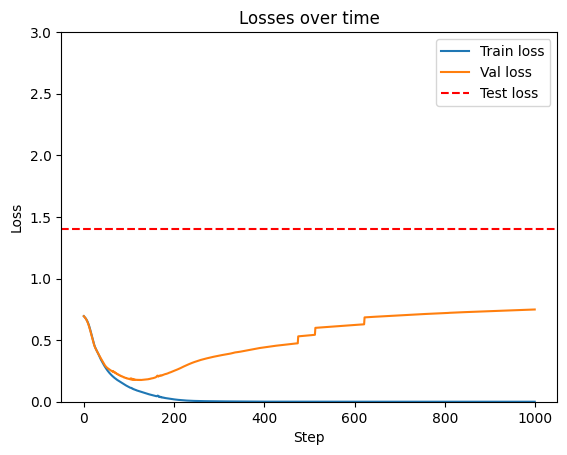

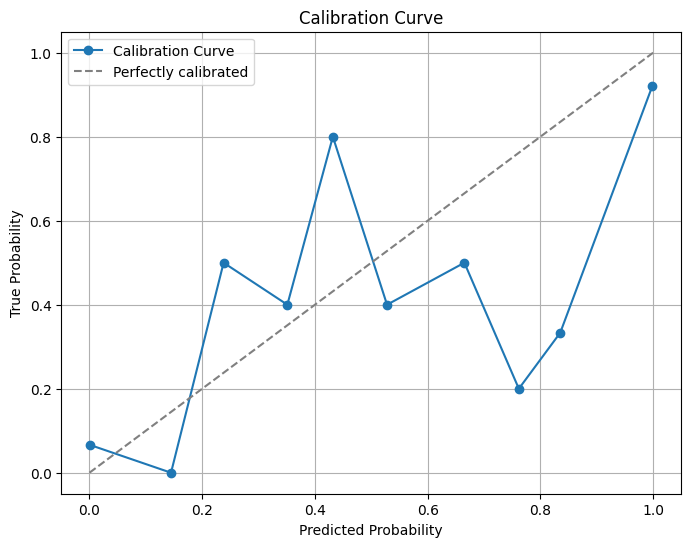

Test accuracy without early stopping: 91.47%
Brier score loss without early stopping: 0.0779


In [58]:
from sklearn.metrics import brier_score_loss

test_loss = loss_fn(model_0(test_data).squeeze(), test_labels).cpu().float().item()
plot_losses(train_losses, val_losses, test_loss)
prob_predictions = model_0(test_data).squeeze().cpu().detach()
plot_calibration_curve(prob_predictions, test_labels)
predictions = (model_0(test_data).squeeze() > 0.5).float()
accuracy = (predictions == test_labels).float().mean().item()
print(f"Test accuracy without early stopping: {accuracy*100:.2f}%")
print(f"Brier score loss without early stopping: {brier_score_loss(test_labels.cpu(), prob_predictions.cpu()):.4f}")

Where the validation loss starts increasing is where the overfitting begins. Let's apply early stopping and see what happens

In [59]:
# train a model with no early stopping
model_1 = SimpleModel(input_size=NUM_FEATURES).to(device)
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
train_losses, val_losses = train_loop(model_1, train_data, train_labels, val_data, val_labels, early_stopping, loss_fn, optimizer)

Epoch 1, Train accuracy: 49.00%   Train Loss: 0.70 | Val accuracy: 56.00%  Val Loss: 0.69
Epoch 2, Train accuracy: 53.19%   Train Loss: 0.69 | Val accuracy: 63.27%  Val Loss: 0.69
Epoch 3, Train accuracy: 61.23%   Train Loss: 0.69 | Val accuracy: 70.53%  Val Loss: 0.68
Epoch 4, Train accuracy: 68.87%   Train Loss: 0.68 | Val accuracy: 71.60%  Val Loss: 0.68
Epoch 5, Train accuracy: 71.30%   Train Loss: 0.68 | Val accuracy: 72.53%  Val Loss: 0.68
Epoch 6, Train accuracy: 72.23%   Train Loss: 0.68 | Val accuracy: 72.87%  Val Loss: 0.67
Epoch 7, Train accuracy: 72.21%   Train Loss: 0.67 | Val accuracy: 72.93%  Val Loss: 0.67
Epoch 8, Train accuracy: 71.99%   Train Loss: 0.67 | Val accuracy: 72.73%  Val Loss: 0.66
Epoch 9, Train accuracy: 72.34%   Train Loss: 0.66 | Val accuracy: 73.60%  Val Loss: 0.66
Epoch 10, Train accuracy: 72.73%   Train Loss: 0.66 | Val accuracy: 73.73%  Val Loss: 0.65
Epoch 11, Train accuracy: 73.24%   Train Loss: 0.65 | Val accuracy: 74.07%  Val Loss: 0.64
Epoch 12

0.22880806028842926


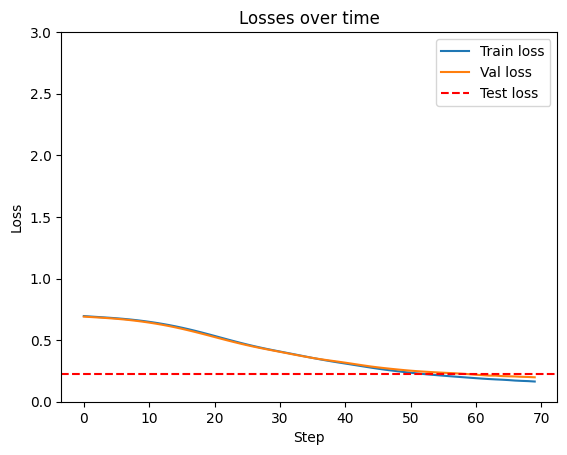

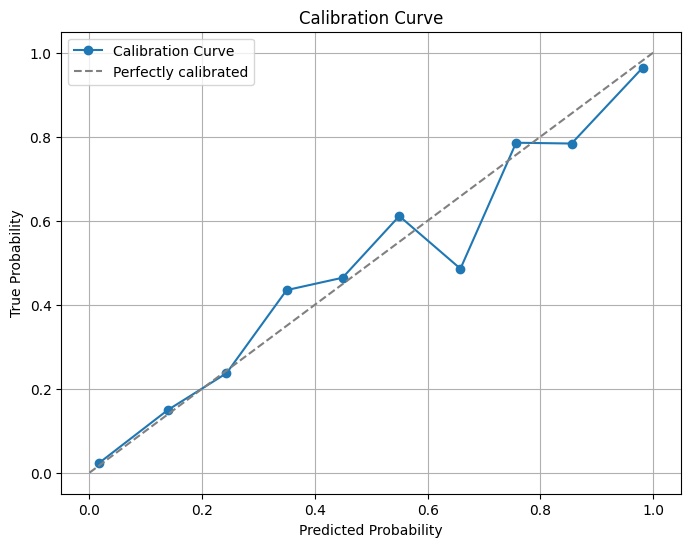

Test accuracy without early stopping: 91.00%
Brier score loss with early stopping: 0.0665


In [60]:
test_loss = loss_fn(model_1(test_data).squeeze(), test_labels).cpu().float().item()
plot_losses(train_losses, val_losses, test_loss)
prob_predictions = model_1(test_data).squeeze().cpu().detach()
plot_calibration_curve(prob_predictions, test_labels)
predictions = (model_1(test_data).squeeze() > 0.5).float()
accuracy = (predictions == test_labels).float().mean().item()
print(f"Test accuracy without early stopping: {accuracy*100:.2f}%")
print(f"Brier score loss with early stopping: {brier_score_loss(test_labels.cpu(), prob_predictions.cpu()):.4f}")

Here we see that training actually stops before we can make the model worse at generalizing. The accuracy of the two models are similar, but because the test loss is much higher on the overfitted model, the overfitted model will be more confident about wrong predictions than incorrect ones. We can see this reflected in the calibration curve, showing that the non-overfitted model seems much better calibrated than the overfitted model. We also see a lower brier score with the early stopping model, further supporting the concept that overfitting should be prevented.

Keep in mind early stopping does not solve the problem that causes overfitting, it merely prevents overfitting by stopping training once it sees it. Actual methods of helping your model to not overfit include hyperparameter tuning, dataset manipulation, etc.